# CNN   small datasets 학습


- Data의 수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 feature를 찾을 수 있는데 있음 
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 이미지의 색깔, 각도 등을 약간씩 변형하여 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용하는 것.
        - 미리 다양한 데이터를 가지고 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown==3.3.1`
- 코랩에는 설치 되어 있음.

In [1]:
!pip install gdown

In [1]:
import gdown
from zipfile import ZipFile

In [8]:
# 이미지 다운로드
# https://drive.google.com/uc?id=공유파일_ID
import gdown

url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'

gdown.download(url, fname, quiet=False) #url, 저장할 경로

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: C:\Users\mein0\1.JupyterNoteCodes\08.DeepLearning\cats_and_dogs_small.zip
90.8MB [00:05, 16.4MB/s]


'cats_and_dogs_small.zip'

In [9]:
# 리눅스 명령어로 디렉토리 생성
!mkdir data

In [29]:
ZipFile.extractall?

In [33]:
with ZipFile('cats_and_dogs_small.zip', 'r') as zf:
    zf.extractall('data/cats_and_dogs_small/')

In [15]:
# 압축풀기  -q: 로그남기지 말아라.   -d 압축을 어디에 풀것인지 디렉토리 지정.
# !unzip -q cats_and_dogs_small.zip -d data/cats_and_dogs_small

'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


## Build a network

- Input: $150 \times 150$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification) 
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지데이터셋을 학습시킨다.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

np.random.seed(1)
tf.random.set_seed(1)

In [79]:
#하이퍼파라미터
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.5
N_EPOCHS = 50
N_BATCHS = 20
IMAGE_SIZE = 150

In [81]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    # classification
    model.add(layers.Flatten())
    model.add(layers.Dropout(DROPOUT_RATE))
    model.add(layers.Dense(units=512, activation='relu'))
    # 출력
    model.add(layers.Dense(units=1, activation='sigmoid'))  #dog/cat : binary classification

    return model

In [5]:
model = create_model()
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              sample_weight_mode=None,
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 92416)             0

In [6]:
# ImageDataGenerator 생성 => Augmentation, 입력 pipeline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_dir = 'data/cats_and_dogs_small/train'
validation_dir = 'data/cats_and_dogs_small/validation'
test_dir = 'data/cats_and_dogs_small/test'

# 구글 COLAB사용시 경로
# train_dir = '/content/data/cats_and_dogs_small/train'
# validation_dir = '/content/data/cats_and_dogs_small/validation'
# test_dir = '/content/data/cats_and_dogs_small/test'

In [7]:
# 1. ImageDataGenerator - No Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Gen.flow_from_directoy() 이용해서 iterator 생성
train_iterator = train_datagen.flow_from_directory(directory=train_dir, # 이미지들의 디렉토리.
                                                   target_size=(IMAGE_SIZE,IMAGE_SIZE), #Resize 크기(height, width)
                                                   class_mode='binary', #dog/cat => binary
                                                   batch_size=N_BATCHS)

validation_iterator = test_datagen.flow_from_directory(directory=validation_dir,
                                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                       class_mode='binary',
                                                       batch_size=N_BATCHS)

test_iterator = test_datagen.flow_from_directory(directory=test_dir,
                                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                       class_mode='binary',
                                                       batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
train_iterator.class_indices

{'cats': 0, 'dogs': 1}

In [10]:
len(train_iterator), len(validation_iterator), len(test_iterator)  #1 에폭당 step 수

(100, 50, 50)


##  Model Training(학습)

In [57]:
model.fit?

In [11]:
history = model.fit(train_iterator, 
                    epochs=N_EPOCHS,
                    steps_per_epoch=len(train_iterator),
                    validation_data=validation_iterator,
                    validation_steps=len(validation_iterator))

Epoch 1/50
100/100 [==============================] - 15s 59ms/step - loss: 1.3773 - accuracy: 0.5230 - val_loss: 0.6913 - val_accuracy: 0.5520
Epoch 2/50
100/100 [==============================] - 6s 55ms/step - loss: 0.6915 - accuracy: 0.5315 - val_loss: 0.6881 - val_accuracy: 0.5090
Epoch 3/50
100/100 [==============================] - 6s 55ms/step - loss: 0.6685 - accuracy: 0.5779 - val_loss: 0.6498 - val_accuracy: 0.5990
Epoch 4/50
100/100 [==============================] - 6s 56ms/step - loss: 0.6246 - accuracy: 0.6576 - val_loss: 0.6213 - val_accuracy: 0.6600
Epoch 5/50
100/100 [==============================] - 6s 55ms/step - loss: 0.5745 - accuracy: 0.6886 - val_loss: 0.5863 - val_accuracy: 0.6730
Epoch 6/50
100/100 [==============================] - 6s 55ms/step - loss: 0.5403 - accuracy: 0.7170 - val_loss: 0.5592 - val_accuracy: 0.7060
Epoch 7/50
100/100 [==============================] - 6s 55ms/step - loss: 0.4852 - accuracy: 0.7582 - val_loss: 0.5703 - val_accuracy: 0.696

In [12]:
model.evaluate(test_iterator)

50/50 [==============================] - 2s 35ms/step - loss: 2.7418 - accuracy: 0.6920


[2.7418298721313477, 0.6919999718666077]

- Overfitting 발생 
    - 원인: 적은 train dataset

In [59]:
tf.__version__

'2.1.0'

# Using data augmentation

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

In [64]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range=(0.7, 1.3),
                                   fill_mode='constant')

# validation, test 용
test_datagen = ImageDataGenerator(rescale=1./255)

In [65]:
train_iterator = train_datagen.flow_from_directory(train_dir, 
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode='binary',
                                                   batch_size=N_BATCHS)

validation_iterator = test_datagen.flow_from_directory(validation_dir, 
                                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                       class_mode='binary',
                                                       batch_size=N_BATCHS)
test_iterator = test_datagen.flow_from_directory(test_dir, 
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary',
                                                 batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [66]:
# 이미지 확인
batch_image = train_iterator.next()
batch_image[0].shape, batch_image[1].shape   #batch_image[0]: image, batch_image[1]: labels

((20, 150, 150, 3), (20,))

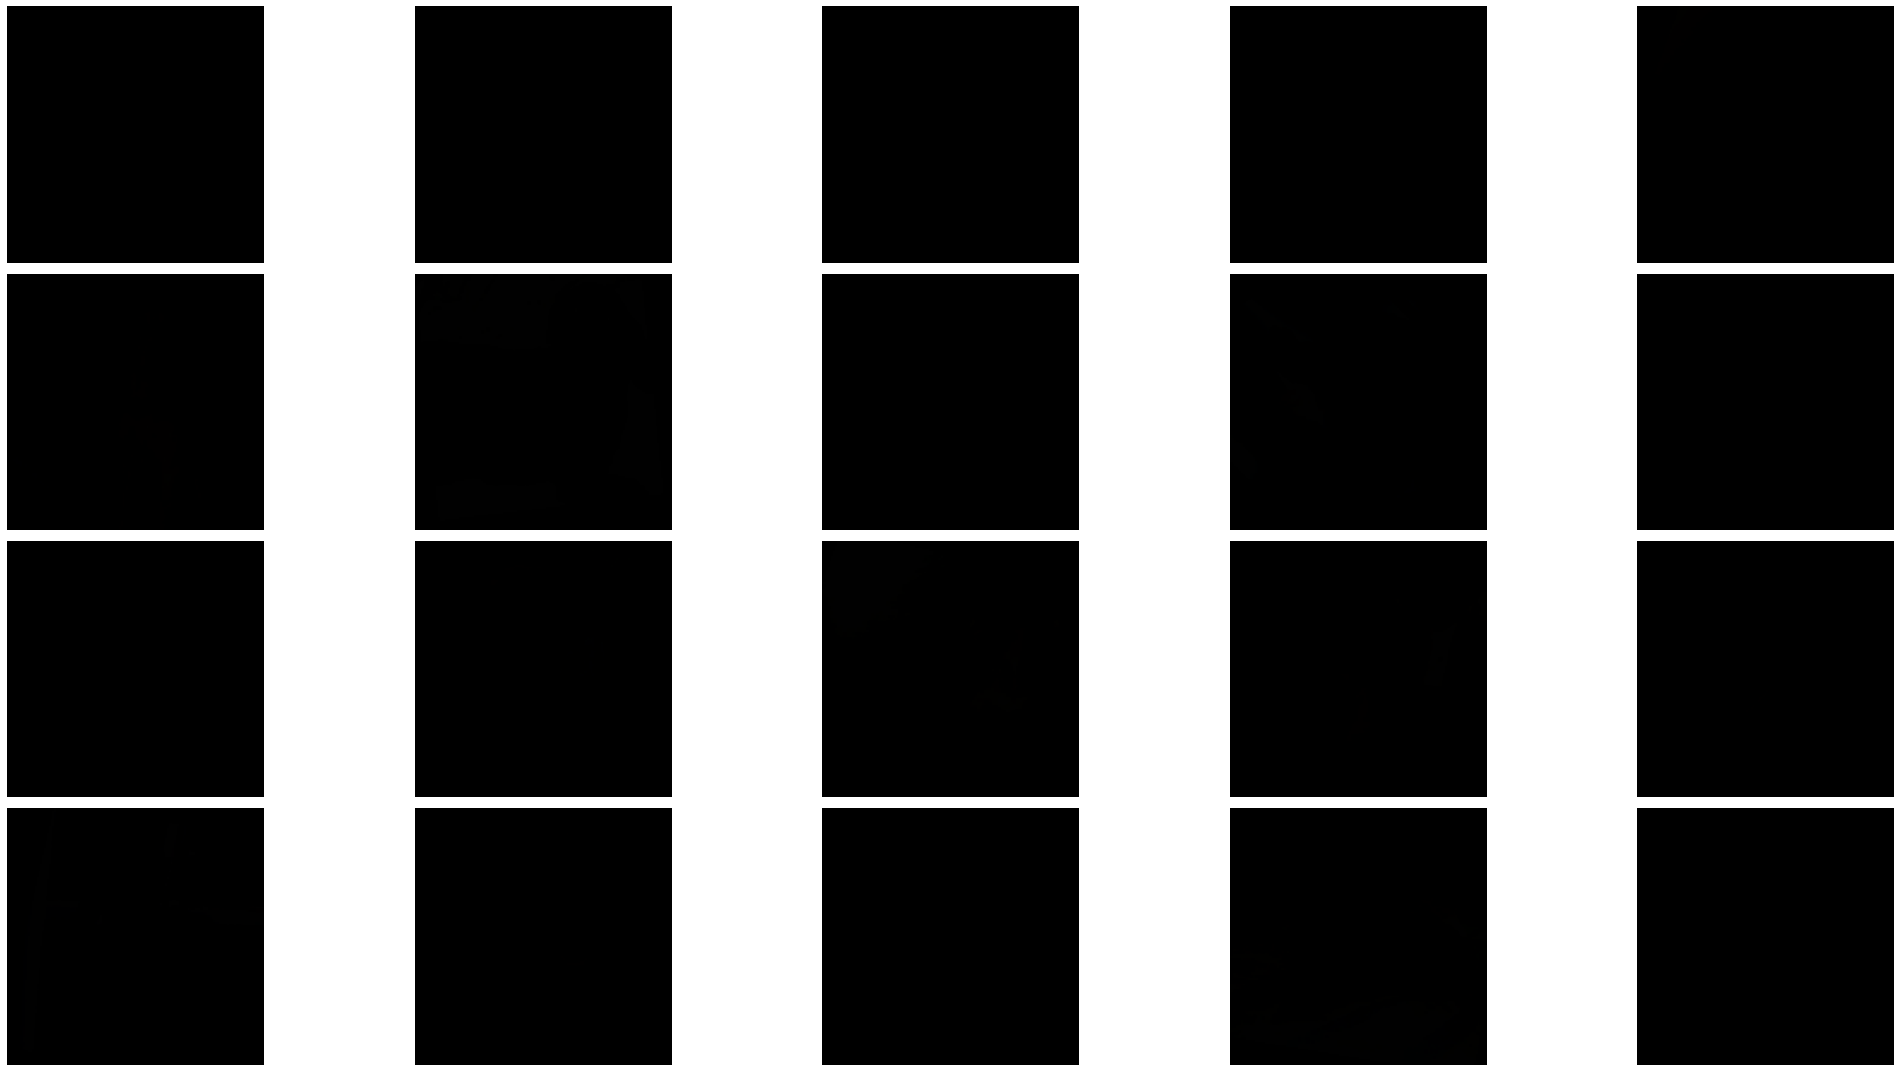

In [67]:
plt.figure(figsize=(30,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    img = batch_image[0][i].astype('uint8')
    plt.imshow(img)
    plt.axis('off')    
plt.tight_layout()
plt.show()

In [68]:
model2 = create_model()
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
model2.fit(train_iterator, 
           epochs=N_EPOCHS,
           steps_per_epoch=len(train_iterator),
           validation_data=validation_iterator,
           validation_steps=len(validation_iterator))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/50
100/100 [==============================] - 13s 135ms/step - loss: 0.7290 - accuracy: 0.5020 - val_loss: 0.6926 - val_accuracy: 0.5030
Epoch 2/50
100/100 [==============================] - 13s 129ms/step - loss: 0.6937 - accuracy: 0.5170 - val_loss: 0.6922 - val_accuracy: 0.5960
Epoch 3/50
100/100 [==============================] - 13s 129ms/step - loss: 0.6913 - accuracy: 0.5265 - val_loss: 0.6904 - val_accuracy: 0.5710
Epoch 4/50
100/100 [==============================] - 13s 131ms/step - loss: 0.6942 - accuracy: 0.5290 - val_loss: 0.6927 - val_accuracy: 0.5420
Epoch 5/50
100/100 [==============================] - 13s 131ms/step - loss: 0.6959 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5030
Epoch 6/50
100/100 [==============================] - 13s 130ms/step - loss: 0.6875 - accuracy: 0.5515 - val_loss: 0.6938 - val_accuracy: 0.5580
Epoch 7/50
100/100 [=================

In [70]:
model.fit(train_iterator, 
           epochs=N_EPOCHS,
           steps_per_epoch=len(train_iterator),
           validation_data=validation_iterator,
           validation_steps=len(validation_iterator))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/50
100/100 [==============================] - 13s 128ms/step - loss: 0.9983 - accuracy: 0.5290 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 2/50
100/100 [==============================] - 13s 129ms/step - loss: 0.6903 - accuracy: 0.5475 - val_loss: 0.6758 - val_accuracy: 0.5460
Epoch 3/50
100/100 [==============================] - 13s 128ms/step - loss: 0.6865 - accuracy: 0.5660 - val_loss: 0.6365 - val_accuracy: 0.6410
Epoch 4/50
100/100 [==============================] - 13s 127ms/step - loss: 0.6387 - accuracy: 0.6260 - val_loss: 0.6189 - val_accuracy: 0.6600
Epoch 5/50
100/100 [==============================] - 13s 128ms/step - loss: 0.6339 - accuracy: 0.6590 - val_loss: 0.5779 - val_accuracy: 0.7130
Epoch 6/50
100/100 [==============================] - 13s 129ms/step - loss: 0.6096 - accuracy: 0.6720 - val_loss: 0.5700 - val_accuracy: 0.7040
Epoch 7/50
100/100 [=================

###  DataFrame 이용
- flow_from_dataframe() 사용
    - 파일경로와 label을 DataFrame으로 저장하고 그것을 이용해 데이터셋을 읽어온다.

In [3]:
import gdown

url = 'https://drive.google.com/uc?id=17ejPJw42TgTv0jCPMMlVTHwF57XYE2kb'
fname = 'cats_and_dogs_union.zip'
gdown.download(url,fname, quiet=True)

'cats_and_dogs_union.zip'

In [4]:
with ZipFile('cats_and_dogs_union.zip', 'r') as zf:
    zf.extractall('../../1. Data/data2/cats_and_dogs/')

In [5]:
# 구글드라이브사용시
# !mkdir data
# !unzip -q ./cats_and_dogs_union.zip -d ./data/cats_and_dogs

# DataFrame 생성
- path, label 컬럼

In [35]:
#파일 경로 다루기 - glob
from glob import glob
# ** 모든 하위경로, *.jpg (확장자가 jpg인 모든 파일)
# path_list = glob("/content/data/cats_and_dogs/**/*.jpg") #지정한 파일들의 absolute path(절대경로)를 문자열로 반환 (리스트에 담아서 반환.)
path_list = glob("..\\..\\1. Data\data2\cats_and_dogs\**\*.jpg") #지정한 파일들의 absolute path(절대경로)를 문자열로 반환 (리스트에 담아서 반환.)
len(path_list)

4000

In [36]:
path_list[:10], path_list[-10:]

(['..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.0.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.1.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.10.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.100.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.1000.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.1001.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.1002.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.1003.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.1004.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\cats\\cat.1005.jpg'],
 ['..\\..\\1. Data\\data2\\cats_and_dogs\\dogs\\dog.990.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\dogs\\dog.991.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\dogs\\dog.992.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\dogs\\dog.993.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\dogs\\dog.994.jpg',
  '..\\..\\1. Data\\data2\\cats_and_dogs\\dogs\\dog.995.jpg',
  '..\

In [15]:
import os 
f = '../../1. Data/data2/cats_and_dogs/dogs/dog.1999.jpg'

print(os.path.basename(f)) # basename(경로): 경로에서 파일명만 추출
print(os.path.dirname(f)) # dirname(경로): 경로에서 디렉토리 부분만 추출
print(os.path.dirname(f).split(r'/')[5])

dog.1999.jpg
../../1. Data/data2/cats_and_dogs/dogs
dogs


In [76]:
label_list = []
for path in path_list:
    l = os.path.dirname(path).split('\\')[5]
    label_list.append(l)

In [60]:
label_list = [os.path.dirname(path).split('\\')[5] for path in path_list]
label_list[:5], label_list[-5:], len(label_list)

(['cats', 'cats', 'cats', 'cats', 'cats'],
 ['dogs', 'dogs', 'dogs', 'dogs', 'dogs'],
 4000)

In [61]:
import pandas as pd
d = {
    "path":path_list,
    "label":label_list
}
data_df = pd.DataFrame(d)
data_df.shape

(4000, 2)

In [62]:
data_df.head()

,path,label
0,..\..\1. Data\data2\cats_and_dogs\cats\cat.0.jpg,cats
1,..\..\1. Data\data2\cats_and_dogs\cats\cat.1.jpg,cats
2,..\..\1. Data\data2\cats_and_dogs\cats\cat.10.jpg,cats
3,..\..\1. Data\data2\cats_and_dogs\cats\cat.100...,cats
4,..\..\1. Data\data2\cats_and_dogs\cats\cat.100...,cats


In [63]:
data_df.tail()

,path,label
3995,..\..\1. Data\data2\cats_and_dogs\dogs\dog.995...,dogs
3996,..\..\1. Data\data2\cats_and_dogs\dogs\dog.996...,dogs
3997,..\..\1. Data\data2\cats_and_dogs\dogs\dog.997...,dogs
3998,..\..\1. Data\data2\cats_and_dogs\dogs\dog.998...,dogs
3999,..\..\1. Data\data2\cats_and_dogs\dogs\dog.999...,dogs


In [64]:
data_df['label'].value_counts()

cats    2000
dogs    2000
Name: label, dtype: int64

In [66]:
data_df.to_csv('cats_and_dogs_filelist.csv', encoding='utf-8', index=None)

In [67]:
# cats, dogs DataFrame으로 분리
cats_df = data_df[data_df['label']=='cats']
dogs_df = data_df[data_df['label']=='dogs']
cats_df.shape, dogs_df.shape

((2000, 2), (2000, 2))

In [69]:
# train/test dataframe을 생성   8:2
split_idx = int(dogs_df.shape[0]*0.8)

In [70]:
train_df = pd.concat([dogs_df[:split_idx], cats_df[:split_idx]], axis=0) #dogs, cats의 0 ~ 1599 (1600)개를 묶어서 train_df 생성
train_df.shape
train_df['label'].value_counts()

cats    1600
dogs    1600
Name: label, dtype: int64

In [71]:
test_df = pd.concat([dogs_df[split_idx:], cats_df[split_idx:]], axis=0)
print(test_df.shape)
test_df['label'].value_counts()

(800, 2)


cats    400
dogs    400
Name: label, dtype: int64

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range=(0.7, 1.3),
                                   fill_mode='constant')

# validation, test 용
test_datagen = ImageDataGenerator(rescale=1./255)

In [80]:
train_iterator = train_datagen.flow_from_dataframe(dataframe=train_df, #path, label을 가진 DataFrame객체를 지정
                                                   x_col='path',  #이미지 경로를 가진 컬럼명
                                                   y_col='label', # label 컬럼명
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode='binary',
                                                   batch_size=N_BATCHS)

test_iterator = test_datagen.flow_from_dataframe(test_df,
                                                 x_col='path',
                                                 y_col='label',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='binary',
                                                 batch_size=N_BATCHS)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [83]:
train_iterator.class_indices

{'cats': 0, 'dogs': 1}

In [84]:
model = create_model()
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 92416)             0

In [85]:
model.fit(train_iterator,
          epochs=N_EPOCHS,
          steps_per_epoch=len(train_iterator),
          validation_data=test_iterator,
          validation_steps=len(test_iterator))

Epoch 1/50
160/160 [==============================] - 23s 115ms/step - loss: 0.8514 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
160/160 [==============================] - 18s 115ms/step - loss: 0.6933 - accuracy: 0.4876 - val_loss: 0.6917 - val_accuracy: 0.4975
Epoch 3/50
160/160 [==============================] - 18s 114ms/step - loss: 0.6944 - accuracy: 0.5164 - val_loss: 0.6928 - val_accuracy: 0.4925
Epoch 4/50
160/160 [==============================] - 18s 115ms/step - loss: 0.6945 - accuracy: 0.5131 - val_loss: 0.6928 - val_accuracy: 0.5075
Epoch 5/50
160/160 [==============================] - 18s 115ms/step - loss: 0.6921 - accuracy: 0.5164 - val_loss: 0.6893 - val_accuracy: 0.5025
Epoch 6/50
160/160 [==============================] - 19s 116ms/step - loss: 0.6905 - accuracy: 0.5186 - val_loss: 0.6887 - val_accuracy: 0.5512
Epoch 7/50
160/160 [==============================] - 18s 114ms/step - loss: 0.6792 - accuracy: 0.5441 - val_loss: 0.6788 - val_ac

## 추론

In [86]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_cat_dog(path):
    class_name = ['cat','dog']
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    # image -> ndarray
    sample = img_to_array(img)[np.newaxis,...]
    # scaling
    sample = sample/255.
    pred = model.predict(sample) # 확률
    print(pred)
    pred = pred[0,0]
    print(pred)
    pred_class = np.where(pred < 0.5, 0, 1)
    print(pred_class)
    pred_class_name = class_name[pred_class]
    return pred, pred_class, pred_class_name

In [87]:
predict_cat_dog('cat.jpg')

[[0.27502316]]
0.27502316
0


(0.27502316, array(0), 'cat')

In [88]:
predict_cat_dog('dog.jpg')

[[0.97358704]]
0.97358704
1


(0.97358704, array(1), 'dog')